# Mount Drive

This section is only if you are working in Google Colab as you will need to mount your Google Drive to the notebook for access to the dataset stored in your Google Drive

In [1]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
# install keras-vggface library
!pip install keras-vggface

# dependencies for keras-vggface to work
!pip install keras_applications
!pip install keras_preprocessing

# package to plot deep learning models
!pip install visualkeras

# replace from keras.engine.topology import get_source_inputs to from keras.utils.layer_utils import get_source_inputs
# in models.py for keras-vggface to work
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 795 kB 11.7 MB/s 


20952

In [3]:
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import numpy as np
from numpy import expand_dims

from keras_vggface.vggface import VGGFace

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import ImageFont
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D

import visualkeras
import pandas as pd

## Google Colab to change directory to current working directory

This section is only if you are working in Google Colab to change to your current working directory so you can access the dataset.

In [4]:
cd drive/MyDrive/Colab\ Notebooks/GA-Capstone/

/content/drive/MyDrive/Colab Notebooks/GA-Capstone


In [5]:
capstone_dir = os.getcwd()

In [6]:
capstone_dir

'/content/drive/MyDrive/Colab Notebooks/GA-Capstone'

# Model Training and Validation

The keras-vggface package is used to import the pre-trained VGGFace model [(*source*)](https://github.com/jbrownlee/keras-vggface) to do trasnfer learning by leveraging the weights trained by the author to use for this project.

In [7]:
# create a vggface model
# include_top=False take out the last layer
# why use pooling='avg'? -> need check out
vgg16_model = VGGFace(model='vgg16')
# model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % vgg16_model.inputs)
print('Outputs: %s' % vgg16_model.outputs)

580083712/580070376 [==============================] - 6s 0us/step
Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'fc8/softmax')>]


In [8]:
vgg16_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

The visualkeras package can be used to show the architecture of any deep learning model. Below shows the architecture of the VGGFace model that will be used for the transfer learning in this project.

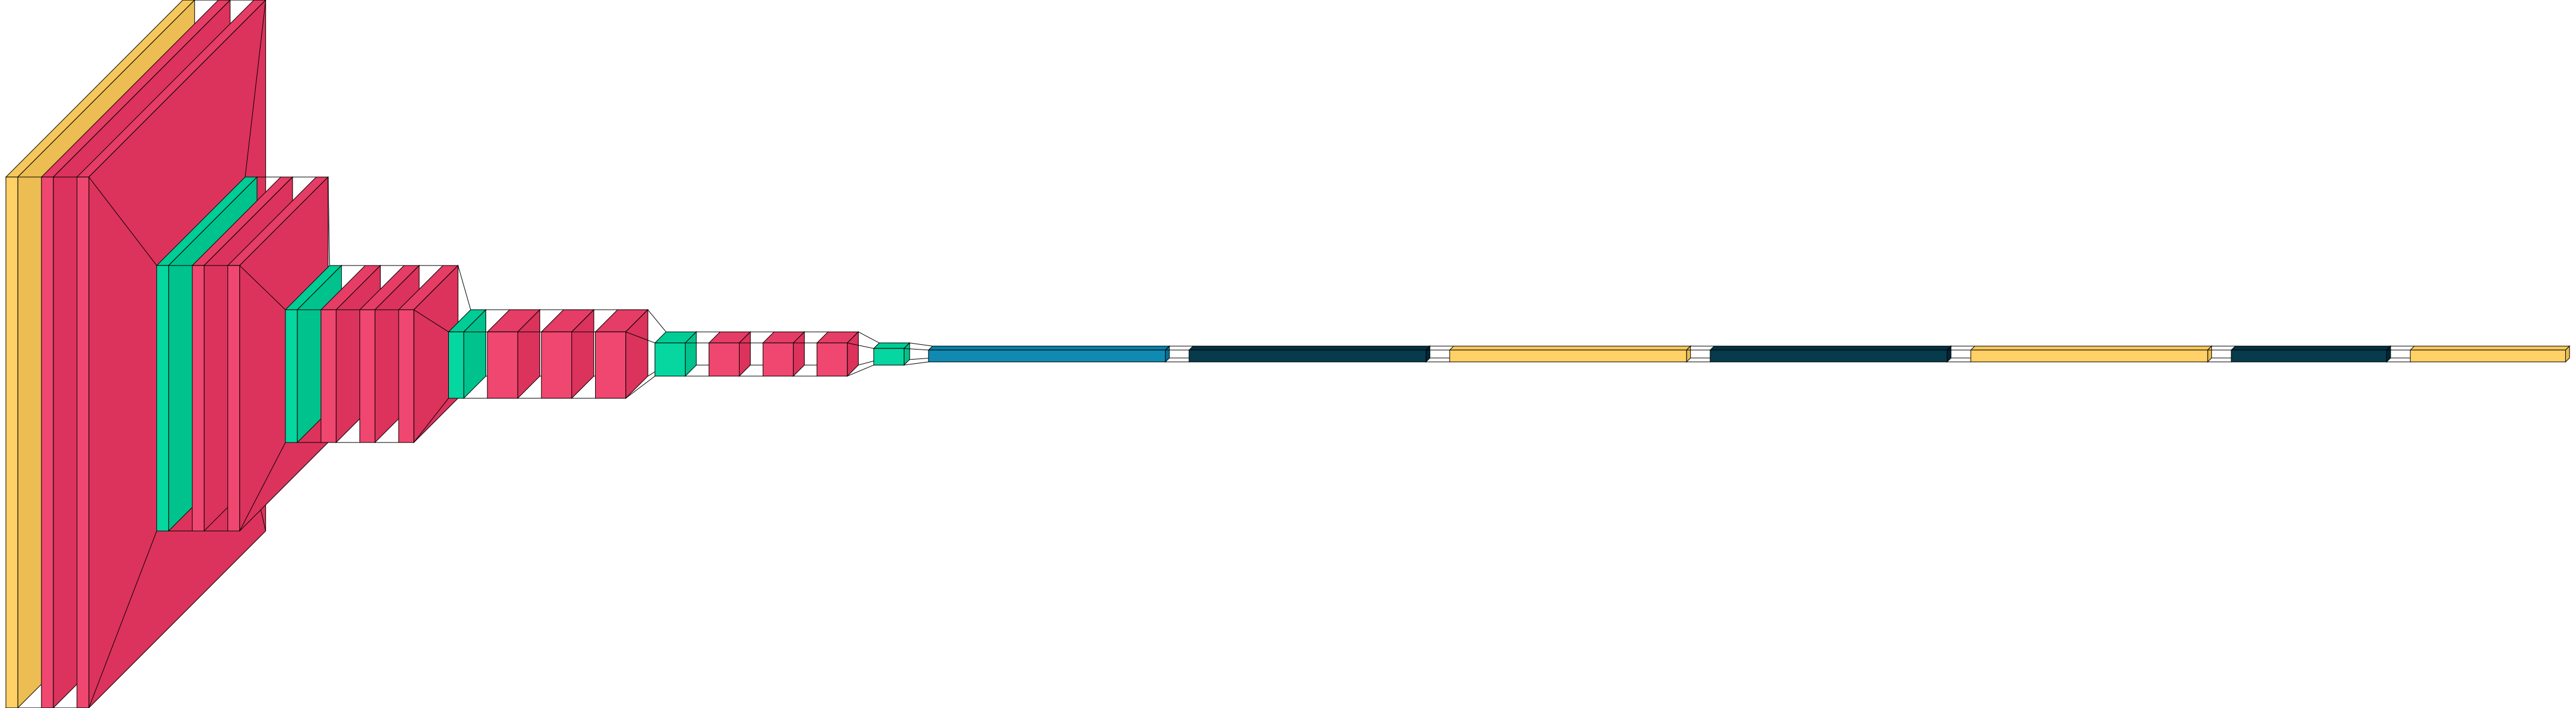

In [21]:
# from PIL import ImageFont
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D

# font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
# visualkeras.layered_view(vgg16_model, legend=True, type_ignore=[ZeroPadding2D, Dropout, Flatten])  # font is optional!
visualkeras.layered_view(vgg16_model, spacing=40)
# visualkeras.layered_view(vgg16_model, spacing=20, legend=True, to_file=os.path.join(capstone_dir, 'figures/vgg16.png')).show() # write and show

## Function to prepare model

In [48]:
# def prepare_model():
#   #custom parameters
#   nb_class = 100
#   hidden_dim = 256

#   # specify input for custom model, model -> resnet50, senet50, vgg16
#   # vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')
#   vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
#   # last_layer = vgg_model.get_layer('avg_pool').output


#   # chain layer
#   # last_layer = vgg_model.output # last layer of vgg_model
#   # x = Flatten(name='flatten')(last_layer)
#   # out = Dense(nb_class, activation='softmax', name='classifier')(x)
#   # vgg_model.summary()
#   # last_layer = vgg_model.get_layer('pool5').output
#   last_layer = vgg_model.output
#   x = Flatten(name='flatten')(last_layer)
#   x = Dense(hidden_dim, activation='relu', name='fc6')(x)
#   x = Dropout(0.5, name='drop1')(x)
#   x = Dense(hidden_dim, activation='relu', name='fc7')(x)
#   x = Dropout(0.5, name='drop2')(x)
#   x = Dense(hidden_dim, activation='relu', name='fc8')(x)
#   x = Dropout(0.5, name='drop3')(x)
#   out = Dense(nb_class, activation='softmax', name='fc9')(x)
  
#   # freeze all pre train model layers
#   # follow by unfreezing last to last 3 layers of pre-trained model for testing, [:-2] to [:-4]
#   for layer in vgg_model.layers[:-1]:
#     layer.trainable = False

#   # instantiate custom model by passing inputs and outputs
#   custom_vgg_model = Model(inputs=vgg_model.input, outputs=out)

#   # compile model
#   custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#   return custom_vgg_model

In [7]:
def prepare_model(layers_dims, layers_name, num_class, model_weights=None, dropout_value=None, dropout_name=None):

  vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)

  # dropout layer present
  if dropout_name and dropout_value:
    for dims, layer, value, name in zip(layers_dims, layers_name[:-1], dropout_value, dropout_name):
      x = Dense(dims, activation='relu', name=layer)(x)
      x = Dropout(value, name=name)(x)
  # dropout layer not present
  else:
    for dims, layer in zip(layers_dims, layers_name[:-1]):
      x = Dense(dims, activation='relu', name=layer)(x)    
  
  out = Dense(num_class, activation='softmax', name=layers_name[-1])(x)
  
  # choose which pre train model layers to freeze
  # if unfreeze last layer with weights to train is -2
  for layer in vgg_model.layers[:-2]:
    layer.trainable = False

  # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=vgg_model.input, outputs=out)

  if model_weights:
    # load pre-trained model weights
    custom_vgg_model.load_weights(model_weights)

  
  # compile model
  custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # custom_vgg_model.compile(loss=CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

  return custom_vgg_model

## Instantiate Model

In this section, model was instantiated using the function defined above. The approach in creating the model here is to remove the classification block from the pre-trained VGGFace model and then attached my own classification block with 2 to 3 fully connected layer together with dropout layers. All the layers of the pre-trained VGGFace model after detaching the classification block are except for the last 2 layers were freezed for training. The model created in this section is not the final model to be used, but is the steps that we can use to create the model for training purpose. At the end of this notebook, we will evaluate the models that have been run. 

In [13]:
# number of classification class
num_class = 100
# layers name for the classification block
model_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']
# number of nodes for each fully connected layer
model_layers_dims = [128, 128, 128]
# dropout value if present
model_dropout_value = [0.1, 0.1, 0.1]
# dropout layer name if present
model_dropout_name = ['drop1', 'drop2', 'drop3']

In [14]:
# create the model
custom_vgg_model = prepare_model(layers_dims=model_layers_dims, layers_name=model_layers_name, num_class=num_class, 
                                dropout_value=model_dropout_value, dropout_name=model_dropout_name)

58925056/58909280 [==============================] - 0s 0us/step


In [46]:
# # # define model
# custom_vgg_model = prepare_model()

In [15]:
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

The output_layers variable here is to specify the folder that the model checkpoint file to be saved when the model is trained. From here onwards, please modify the path accordingly to get to the correct directory for accessing the data or creating folders for saving of model checkpoints. PLEASE NOTE that the data path specified in this notebook is only valid for working in Google Colab. YOU WILL. NEED TO EDIT THE PATH ACCORDINGLY to where your dataset or your folders are.

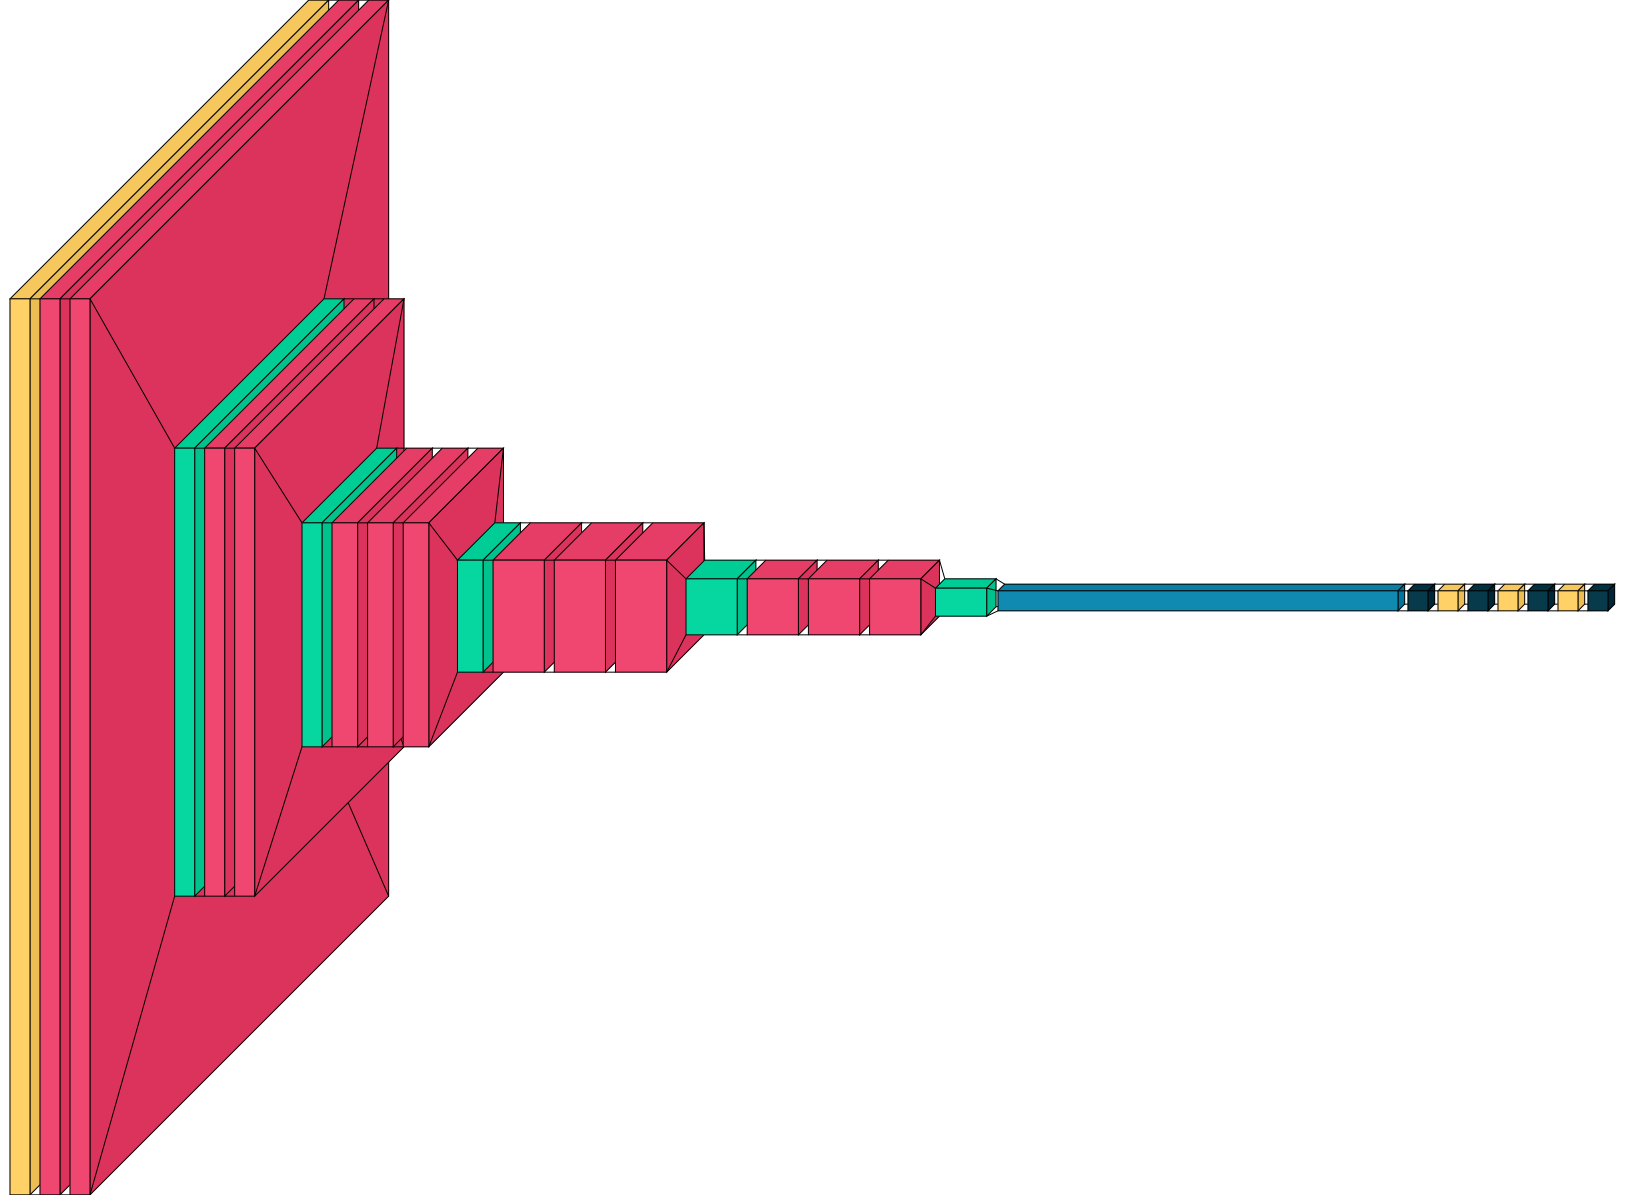

In [16]:
output_layers = 'model4'
# visualkeras.layered_view(custom_vgg_model, to_file=os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}.png')).show() # write and show
visualkeras.layered_view(custom_vgg_model)

## Load train, validation and test data with ImageDataGenerator

In [8]:
# need pass in the preprocess function for the vggface
# datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
datagen = ImageDataGenerator(rescale=1./255)

In [19]:
%%time
# Similarly, if a validation iterator is applied, then the ‘validation_steps‘ argument must also be specified 
# to indicate the number of batches in the validation dataset defining one epoch
# load and iterate training dataset
# target size set to the input of vgg model
train_it = datagen.flow_from_directory('dataset/processed-dataset/train/', target_size=(224, 224), class_mode='categorical', batch_size=64)

# load and iterate validation dataset
val_it = datagen.flow_from_directory('dataset/processed-dataset/val/', target_size=(224, 224), class_mode='categorical', batch_size=64)

# # load and iterate test dataset
# test_it = datagen.flow_from_directory('dataset/processed-dataset/test/', target_size=(224, 224), class_mode='categorical', batch_size=64)

Found 15229 images belonging to 100 classes.
Found 4371 images belonging to 100 classes.
CPU times: user 649 ms, sys: 67 ms, total: 716 ms
Wall time: 30.9 s


In [20]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 224, 224, 3), min=0.000, max=1.000


## Specify path to save Model Checkpoint using callback function

In [27]:
# specify checkpoint path
# checkpoint_path = "model_checkpoint/vgg/cp.ckpt"
checkpoint_path = f"model_checkpoint/vgg/{output_layers}"
# checkpoint_path = f"weights.{epoch:02d}-{val_loss:.2f}.hdf5"
if os.path.isdir(checkpoint_path) is False:
  os.mkdir(checkpoint_path)

In [28]:
# Callback functions are applied at different stages of training to give a view on the internal training states.
# We create a callback function to save the model weights using ModelCheckpoint.
# If we set save_weight_only to True, then only the weights will be saved. Model architecture, loss, and the optimizer will not be saved.
# We can also specify if we want to save the model at every epoch or every n number of epochs

# Create a callback that saves the model's weights
# monitor - def val_loss -> change to val_accuracy
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, "weights.epoch{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}acc.hdf5"),
    # filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)
# Create a callback for early stopping
early = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    verbose=1
)

## Model Training

For a start, the early stopping callback is not included in the callbacks function to let the models train enough epochs so that we can get a feel on the accuracy for both the training and validation set. Subsequently, we can include the early stoping in the callback function to stop the training if the validation accuracy does not improve for some epochs number so as to save time. The checkpoint callback is used to save the model checkpoint weights if the a better validation accuracy is achieved, The best model weights for each of the model that was run through will be evaluated at the end of the notebook.

In [49]:
%%time
# takes 2hr 20min for basic (2layers followed by softmax), unfreeze last pre-trained model layers
# For example, fitting a model with a data generator can be achieved by calling the fit_generator() function on 
# the model and passing the training iterator (train_it). The validation iterator (val_it) can be specified 
# when calling this function via the ‘validation_data‘ argument.

# The ‘steps_per_epoch‘ argument must be specified for the training iterator in order to define how many batches 
# of images defines a single epoch.

# For example, if you have 1,000 images in the training dataset (across all classes) and a batch size of 64, 
# then the steps_per_epoch would be about 16, or 1000/64.

# fit model
# fit_generator deprecated, use fit() instead
history = custom_vgg_model.fit(train_it, steps_per_epoch=238, 
                               validation_data=val_it, validation_steps=69, 
                               epochs=50, callbacks=[checkpoint, early])

Epoch 1/50
238/238 [==============================] - 63s 263ms/step - loss: 0.0840 - accuracy: 0.9768 - val_loss: 1.4340 - val_accuracy: 0.7289

Epoch 00001: val_accuracy did not improve from 0.75040
Epoch 2/50
238/238 [==============================] - 61s 258ms/step - loss: 0.0837 - accuracy: 0.9775 - val_loss: 1.5045 - val_accuracy: 0.7298

Epoch 00002: val_accuracy did not improve from 0.75040
Epoch 3/50
238/238 [==============================] - 61s 257ms/step - loss: 0.0982 - accuracy: 0.9740 - val_loss: 1.5245 - val_accuracy: 0.7223

Epoch 00003: val_accuracy did not improve from 0.75040
Epoch 4/50
238/238 [==============================] - 60s 252ms/step - loss: 0.1140 - accuracy: 0.9722 - val_loss: 1.5962 - val_accuracy: 0.7127

Epoch 00004: val_accuracy did not improve from 0.75040
Epoch 5/50
238/238 [==============================] - 59s 250ms/step - loss: 0.1021 - accuracy: 0.9741 - val_loss: 1.6169 - val_accuracy: 0.7170

Epoch 00005: val_accuracy did not improve from 0.7

### Plot the training and validation loss and accuracy

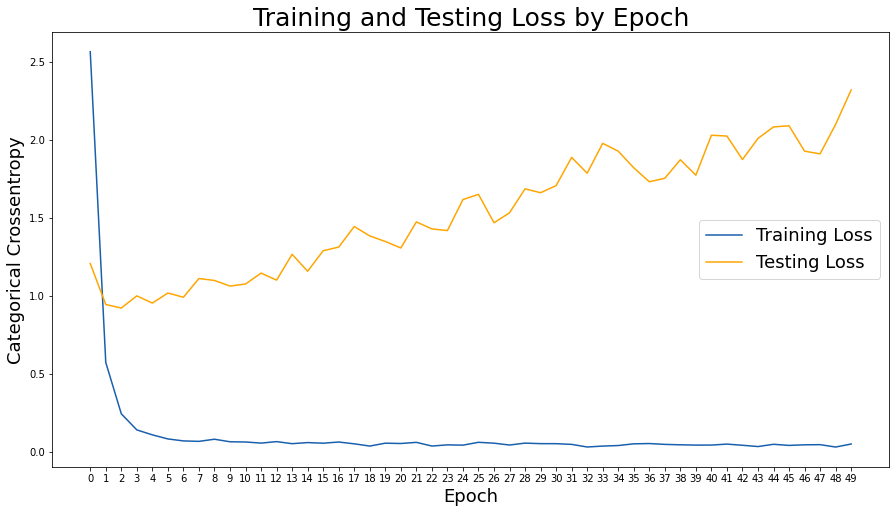

In [21]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(15, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18)

# save the figure
plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_loss.png'), dpi=300, bbox_inches='tight')

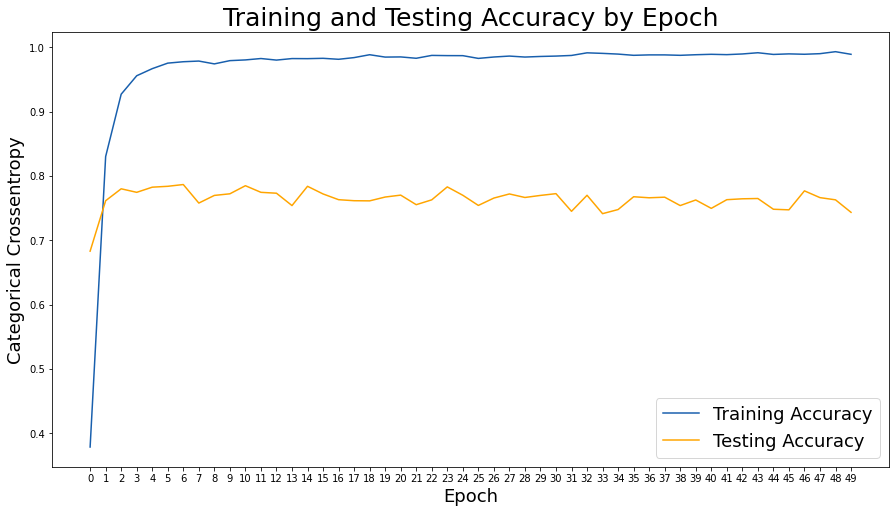

In [22]:
# Check out our train loss and test loss over epochs.
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(15, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

# save the figure
plt.savefig(os.path.join(capstone_dir, f'figures/custom_vgg16_{output_layers}_acc.png'), dpi=300, bbox_inches='tight')

### Summary of the model trained

8 models were trained altogether and the table below shows the performance of each of the models. These 8 models will be evaluated using the test dataset in the next section

Model  | Hidden Layer Nodes | Dropout Layers Value | Training Accuracy | Validation Accuracy | Remarks
-------------------|------------------|-------------------|------------------|------------------|------------------
Base Model | [128, 128] | - | 99% | 73.2% | Trained the last trainable layer of VGGFace
Base Model 2 | [128, 128] | - | 98.9% | 64.5% | Trained the last 2 trainable layers of VGGFace
Model 1 | [128, 128] | [0.1, 0.1] | 99% | 75% | Trained the last trainable layer of VGGFace
Model 2 | [256, 256] | [0.3, 0.3] | 97.8% | 78.7% | Trained the last trainable layer of VGGFace
Model 3 | [512, 512] | [0.4, 0.4] | 96.8% | 77.2% | Trained the last trainable layer of VGGFace
Model 4 | [128, 128, 128] | [0.1, 0.1] | 98.8% | 74.3% | Trained the last trainable layer of VGGFace
Model 5| [256, 256, 256] | [0.3, 0.3] | 97.4% | 75% | Trained the last trainable layer of VGGFace
Model 6 | [512, 512, 512] | [0.4, 0.4] | 96.7% | 75.3% | Trained the last trainable layer of VGGFace

In [ ]:
# # It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model("model/my_model")

In [ ]:
# # Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

In [ ]:
# # Once the model is fit, it can be evaluated on a test dataset using the evaluate_generator() function 
# # and passing in the test iterator (test_it). The ‘steps‘ argument defines the number of batches of samples 
# # to step through when evaluating the model before stopping

# # evaluate model
# loss = model.evaluate_generator(test_it, steps=35)

In [ ]:
# # Finally, if you want to use your fit model for making predictions on a very large dataset, 
# # you can create an iterator for that dataset as well (e.g. predict_it) and call the predict_generator() function 
# # on the model make a prediction
# yhat = model.predict_generator(test_it, steps=35)

# Model Evaluation

In [9]:
# load and iterate test dataset
test_it = datagen.flow_from_directory('dataset/processed-dataset/test/', target_size=(224, 224), class_mode='categorical', batch_size=64)

Found 2189 images belonging to 100 classes.


## Base Model

The base model attached 2 fully connected layers with each layers having 128 nodes was selected as smaller number of nodes to reduce the time for the mode to train, hence can be a starting point for us to optimize in the later stage. The last trainable layer of the pre-trained VGGFace is set to True for training. For this base model, a validation accuracy of 73.2% was achieved when training in the previous section.

In [12]:
# number of classification class
num_class = 100
# layers name for the classification block
# 2 hidden + 1 output
two_layers_name = ['fc6', 'fc7', 'fc8']
# number of nodes for each fully connected layer
base_model_layers_dims = [128, 128]
# path for the model weights
base_model_path = "model_checkpoint/vgg/base_model/weights.epoch10-0.7319acc.hdf5"

In [13]:
base_model = prepare_model(layers_dims=base_model_layers_dims, layers_name=two_layers_name, 
                          num_class=num_class, model_weights=base_model_path)

58925056/58909280 [==============================] - 1s 0us/step


In [26]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [14]:
%%time
base_model.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 492s 14s/step - loss: 1.1341 - accuracy: 0.7853
CPU times: user 15.3 s, sys: 2.16 s, total: 17.5 s
Wall time: 8min 26s


[1.1341016292572021, 0.7852900624275208]

## Base Model 2

The difference between this model and the Base Model above is that the last 2 trainable layers of the pre-trained VGGFace are set to True for training to see if the accuracy will improve by training more weights on the VGGFace model. However, this is not the case as the validation accuracy drop from 73.2% to 64.5% which was run in the previous section on the model training part.

In [15]:
base_model2_path = "model_checkpoint/vgg/base_model2/weights.epoch17-0.6447acc.hdf5" 

In [16]:
base_model2 = prepare_model(layers_dims=base_model_layers_dims, layers_name=two_layers_name, 
                            num_class=num_class, model_weights=base_model2_path)

In [33]:
base_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [17]:
%%time
base_model2.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 212ms/step - loss: 3.0956 - accuracy: 0.6546
CPU times: user 6.1 s, sys: 739 ms, total: 6.84 s
Wall time: 8.2 s


[3.095583200454712, 0.654636800289154]

From the comparison on the 2 Base Models that were trained previously, the model with the lesser layers of the VGGFace being trained achieved a better validation accuracy. Hence, from here onwards, all the model will only train on the last trainable layer of the VGGFace Model.

## Model 1

Model 1 add the dropout layers in between of the hidden layers and input/output layers as the training and validation accuracy differ by more than 20%, hence dropout layers are added to see if we can overcome this overfitting issue. The validation accuracy actually increase from 73.2% to 75% with the adding of dropout layers.

In [18]:
# path for the model weights
model1_path = "model_checkpoint/vgg/model1/weights.epoch15-0.9898-0.7499acc.hdf5"
# dropout layer value
model1_dropout_value = [0.1, 0.1]
# dropout layer name
two_layers_dropout_name = ['drop1', 'drop2']

In [19]:
model1 = prepare_model(layers_dims=base_model_layers_dims, layers_name=two_layers_name, 
                       num_class=num_class, model_weights=model1_path, dropout_value=model1_dropout_value, 
                       dropout_name=two_layers_dropout_name)

In [37]:
model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [20]:
%%time
model1.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 210ms/step - loss: 1.2796 - accuracy: 0.7634
CPU times: user 6.03 s, sys: 814 ms, total: 6.84 s
Wall time: 10.9 s


[1.2796109914779663, 0.7633622884750366]

## Model 2

Model 2 increase the 2 hidden layer nodes from 128 to 256 to see if the validation accuracy will improve and it has been observed that it improved from 75% to 78.7%.

In [21]:
# path for the model weights
model2_path = "model_checkpoint/vgg/model2/weights.epoch07-0.9777-0.7868acc.hdf5"
# dropout layer value
model2_dropout_value = [0.3, 0.3]
# number of nodes for each fully connected layer
model2_layers_dims = [256, 256]

In [23]:
model2 = prepare_model(layers_dims=model2_layers_dims, layers_name=two_layers_name, 
                       num_class=num_class, model_weights=model2_path, dropout_value=model2_dropout_value, 
                       dropout_name=two_layers_dropout_name)

In [44]:
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [24]:
%%time
model2.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 211ms/step - loss: 0.8666 - accuracy: 0.8145
CPU times: user 6.19 s, sys: 741 ms, total: 6.93 s
Wall time: 8.27 s


[0.8665503263473511, 0.814527153968811]

## Model 3

Model 3 increase the 2 hidden layer nodes from 256 to 512 to see if the validation accuracy can be further improved and it has been observed that it actually dropped from 78.7%% to 77.2%. Hence, this might be due to overfitting as more features are trained for this model which might have some correlation with other features.

In [25]:
# path for the model weights
model3_path = "model_checkpoint/vgg/model3/weights.epoch04-0.9676-0.7719acc.hdf5"
# dropout layer value
model3_dropout_value = [0.4, 0.4]
# number of nodes for each fully connected layer
model3_layers_dims = [512, 512]

In [26]:
model3 = prepare_model(layers_dims=model3_layers_dims, layers_name=two_layers_name, 
                       num_class=num_class, model_weights=model3_path, dropout_value=model3_dropout_value, 
                       dropout_name=two_layers_dropout_name)

In [52]:
model3.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [27]:
%%time
model3.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 211ms/step - loss: 0.8207 - accuracy: 0.8017
CPU times: user 6.09 s, sys: 756 ms, total: 6.85 s
Wall time: 10.9 s


[0.8207234740257263, 0.8017359375953674]

## Model 4



In [28]:
# path for the model weights
model4_path = "model_checkpoint/vgg/model4/weights.epoch24-0.9880-0.7431acc.hdf5"
# dropout layer value
model4_dropout_value = [0.1, 0.1, 0.1]
# number of nodes for each fully connected layer
model4_layers_dims = [128, 128, 128]
# dropout layer name
three_layers_dropout_name = ['drop1', 'drop2', 'drop3']
# layers name for the classification block
# 3 hidden + 1 output
three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']

In [29]:
model4 = prepare_model(layers_dims=model4_layers_dims, layers_name=three_layers_name, 
                       num_class=num_class, model_weights=model4_path, dropout_value=model4_dropout_value, 
                       dropout_name=three_layers_dropout_name)

In [56]:
model4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [30]:
%%time
model4.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 211ms/step - loss: 1.2675 - accuracy: 0.7816
CPU times: user 6.16 s, sys: 724 ms, total: 6.89 s
Wall time: 10.9 s


[1.2675036191940308, 0.7816354632377625]

## Model 5

In [34]:
# path for the model weights
# model5_path = "model_checkpoint/vgg/model5/weights.epoch18-0.9781-0.7504acc.hdf5"
model5_path = "model_checkpoint/vgg/model5/weights.epoch13-0.9735-0.7499acc.hdf5"
# dropout layer value
model5_dropout_value = [0.3, 0.3, 0.3]
# number of nodes for each fully connected layer
model5_layers_dims = [256, 256, 256]

In [35]:
model5 = prepare_model(layers_dims=model5_layers_dims, layers_name=three_layers_name, 
                       num_class=num_class, model_weights=model5_path, dropout_value=model5_dropout_value, 
                       dropout_name=three_layers_dropout_name)

In [61]:
model5.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [36]:
%%time
model5.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 212ms/step - loss: 1.0722 - accuracy: 0.7839
CPU times: user 6.14 s, sys: 710 ms, total: 6.85 s
Wall time: 10.9 s


[1.0721935033798218, 0.7839195728302002]

## Model 6

In [37]:
# path for the model weights
model6_path = "model_checkpoint/vgg/model6/weights.epoch11-0.9672-0.7531acc.hdf5"
# dropout layer value
model6_dropout_value = [0.4, 0.4, 0.4]
# number of nodes for each fully connected layer
model6_layers_dims = [512, 512, 512]

In [38]:
model6 = prepare_model(layers_dims=model6_layers_dims, layers_name=three_layers_name, 
                       num_class=num_class, model_weights=model6_path, dropout_value=model6_dropout_value, 
                       dropout_name=three_layers_dropout_name)

In [65]:
model6.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [39]:
%%time
model6.evaluate(test_it, batch_size=64, verbose=1)

35/35 [==============================] - 8s 212ms/step - loss: 1.0771 - accuracy: 0.7711
CPU times: user 6.14 s, sys: 701 ms, total: 6.84 s
Wall time: 10.9 s


[1.0771305561065674, 0.7711283564567566]

## Summary of model evaluation

These 8 models were evaluated using the test dataset and the table below shows the performance of each of the models. 

Model  | Hidden Layer Nodes | Dropout Layers Values | Training Accuracy | Validation Accuracy | Test Accuracy | Remarks
-------------------|------------------|-------------------|------------------|------------------|--------------------|------------------|
Base Model | [128, 128] | - | 99% | 73.2% | 78.5% | Trained the last trainable layer of VGGFace
Base Model 2 | [128, 128] | - | 99% | 64.5% | 75.5% | Trained the last 2 trainable layers of VGGFace
Model 1 | [128, 128] | [0.1, 0.1] | 99% | 75% | 76.3% | Trained the last trainable layer of VGGFace
Model 2 | [256, 256] | [0.3, 0.3] | 97.8% | 78.7% | 81.5% | Trained the last trainable layer of VGGFace
Model 3 | [512, 512] | [0.4, 0.4] | 96.8% | 77.2% | 80.2% | Trained the last trainable layer of VGGFace
Model 4 | [128, 128, 128] | [0.1, 0.1, 0.1] | 98.8% | 74.3% | 78.2% | Trained the last trainable layer of VGGFace
Model 5| [256, 256, 256] | [0.3, 0.3, 0.3] | 97.4% | 75% | 78.4% | Trained the last trainable layer of VGGFace
Model 6 | [512, 512, 512] | [0.4, 0.4, 0.4] | 96.7% | 75.3% | 77.1% | Trained the last trainable layer of VGGFace

As this project is to identify people of interest, other than the accuracy, the cosine similarity of the 2 facial images is also an important metric. Hence, the Base Model, Model1, Model2, Model3, Model4, Model5 and Model 6 were selected to test for the cosine similarity in the Model Testing notebook as the models have good accuracy for all 3 training, validation and test sets.